# Optimization of Sao Paulo traffic

Lead author: Jules Deschamps.

This notebook presents a simple use case of *information geometry*, in the context of *traffic optimization* in Sao Paulo.
We rely on a dataset listing all traffic jams in Sao Paulo for the past two decades (their location, date, their size, their duration, i.e. how long the traffic was jammed) to propose a solution involving information geometry.

This analysis relies heavily on the geometry of the *Gamma manifold*, which is particularly adapted to addressing this situation, as seen later on.

<center>
    <img src='_63032028_jam_ap624.jpg' width=600px>
</center>

<center>
    Figure 1: Sao Paulo: A city with 180km traffic jams -- BBC News
</center>

# 1. Introduction and Motivation

40% of São Paulo residents own a motor vehicle. While this is lower than cities in the United States, it is still higher than most other Latin American cities and São Paulo’s infrastructure was not built to accommodate such a large number of private vehicles. As The Urban Mobility Research Network of São Paulo found, some São Paulo residents spend one month per year in traffic, or 2.4 hours per day. As car ownership increases, and with it further congestion, this time spent in traffic will only grow. In that regard, considering the increase in car ownership and air pollution, even though widening roads only brings a temporary solution, it can alleviate Brazilians of the absurd amount of time they spend in traffic.

In the role of Sao Paulo's city planners, we have been granted a certain amount of resources to solve the congestion problem of Sao Paulo. The issue at hand becomes that of choosing which roads to renovate. More formally, the goal is eventually to reduce the mean expected congestion time in traffic.

### Setup

In [1]:
import warnings

warnings.filterwarnings("ignore")

import geomstats.backend as gs
import pandas as pd
from tqdm import tqdm

gs.random.seed(2021)

INFO: Using pytorch backend


# 2. Dataset description

We have at our disposal a dataset containing traffic jam size measurements by CET at several locations on São Paulo between 2001 and 2019, with more than 5M entries.

Available columns:
- passage (str) - Name of the passage
- direction (str)
- type (str) - Indicates if the passage is an expressway (E)
- region (str) - São Paulo region
- timestamp (datetime) - When the traffic jam was measured (UTC-4)
- jam_size (int) - Traffic jam in meters
- segment (str) - Where the passage is located

Our modeling does not take into account the fact that many of the passages/roads must have been renovated between 2001 and 2019. Similarly, the dataset does not offer information on the width of given roads (even though we could base it off of the type of the road), and therefore on their flow rate: this is an obvious flaw in our analysis but it is easy to fix if the relevant data can be accessed.

## Reading the dataset

In [2]:
ds = pd.read_feather("sao_paulo-traffic_jams.feather")
ds

,index,passage,direction,type,region,timestamp,jam_size,segment
0,0,"Jânio Quadros, Túnel",unico//,NaN,OESTE,2015-01-04 14:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
1,1,"Juscelino Kubitschek, Av Pres",Ibirapuera/Pinheiros,NaN,SUL,2015-01-04 14:30:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...
2,2,"Jânio Quadros, Túnel",unico//,NaN,OESTE,2015-01-04 15:00:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
3,3,"Juscelino Kubitschek, Av Pres",Ibirapuera/Pinheiros,NaN,SUL,2015-01-04 15:00:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...
4,4,"Jânio Quadros, Túnel",unico//,NaN,OESTE,2015-01-04 15:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
...,...,...,...,...,...,...,...,...
5223443,230195,Marginal Pinheiros,Interlagos/Castelo,A,OESTE,2018-09-30 18:30:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...
5223444,230196,Marginal Pinheiros,Interlagos/Castelo,E,OESTE,2018-09-30 19:00:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...
5223445,230197,Marginal Pinheiros,Interlagos/Castelo,A,OESTE,2018-09-30 19:00:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...
5223446,230198,Marginal Pinheiros,Interlagos/Castelo,E,OESTE,2018-09-30 19:30:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...


## Pre-processing the dataset

Some of the columns of the dataset are not necessary for our study: let alone __index__, __type__ and __segment__ do not seem to add any value to the table in our case. In addition, the times (__timestamp__) at which jams are occurring are not relevant in that specific format: it would make much more sense to have the duration of given jam. For reasons we will explain later, we alos decide to drop the __jam_size__ column.

We would want to transform the original dataset so as to access a more relevant table, with features:
- name of the road (primary key = passage + direction for instance, segments are regrouped within same key)
- date (day only)
- duration of the traffic jam


In [3]:
def datetime_to_hours(time):
    return time.hour + time.minute/60

ds["date"], ds["time"] = pd.to_datetime(ds['timestamp']).dt.date, (pd.to_datetime(ds['timestamp']).dt.time).apply(datetime_to_hours)
ds = ds.drop(['index', 'region', 'type', 'timestamp', 'jam_size', 'segment'], axis=1)

The list *points* concatenates all primary keys.

In [4]:
roads = list(ds.groupby(['passage', 'direction']).groups)
print(f"There are {len(roads)} primary keys.")

There are 474 primary keys.



An additional dictionary giving the frequency of traffic jams for each road would be convenient to understand which roads are in most need for renovation. Here *jam_count* counts the number of traffic jams that have occurred for each road between 2001 and 2019.

In [5]:
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    sequences = list(zip(edges, edges))
    consecutives = [sequence[-1] - sequence[0] + 1.0 for sequence in sequences]
    return gs.array(consecutives)

In [6]:
passages, directions, dates, durations = [], [], [], []

jam_count = dict.fromkeys([key[0] + key[1] for key in roads], 0)

LENGTH = len(roads)

pbar = tqdm(total=LENGTH)

for point in roads:
    pbar.update(n=1)
    passage, direction = point
    dataframe = ds.loc[(ds["passage"] == passage) & (ds["direction"] == direction)]
    for date in dataframe["date"].unique():
        times = 2.0 * gs.array(list(dataframe.loc[dataframe["date"] == date]["time"]))
        jam_count[passage + direction] += len(times)
        congestion_times = .5 * ranges(times)
        for duration in congestion_times:
            try:
                passages.append(passage)
                directions.append(direction)
                dates.append(date)
                durations.append(duration)
            except:
                continue

100%|█████████▉| 472/474 [33:51<00:15,  7.51s/it]  

In [7]:
dict = {"passage": passages, "direction": directions, "date": dates, "duration": durations}
df = pd.DataFrame.from_dict(dict)
df

,passage,direction,date,duration
0,"Abraão Ribeiro, Av Dr (F)",Bairro/Centro,2005-01-12,tensor(1.)
1,"Abraão Ribeiro, Av Dr (F)",Bairro/Centro,2005-01-20,tensor(1.5000)
2,"Abraão Ribeiro, Av Dr (F)",Bairro/Centro,2005-01-21,tensor(1.5000)
3,"Abraão Ribeiro, Av Dr (F)",Bairro/Centro,2005-02-24,tensor(4.5000)
4,"Abraão Ribeiro, Av Dr (F)",Bairro/Centro,2005-02-28,tensor(2.)
...,...,...,...,...
650519,"Xangai, Vd",unico//,2004-01-16,tensor(3.5000)
650520,"Xangai, Vd",unico//,2004-03-24,tensor(4.)
650521,"Xangai, Vd",unico//,2004-03-26,tensor(2.)
650522,"Xangai, Vd",unico//,2004-04-29,tensor(4.)


We hardwrite the table so as not to run the same operations every time :).

In [8]:
df.to_csv("clean_table")

In [12]:
df_test = pd.read_csv("clean_table")
df_test

,Unnamed: 0,passage,direction,date,duration
0,0,"Abraão Ribeiro, Av Dr (F)",Bairro/Centro,2005-01-12,1.0
1,1,"Abraão Ribeiro, Av Dr (F)",Bairro/Centro,2005-01-20,1.5
2,2,"Abraão Ribeiro, Av Dr (F)",Bairro/Centro,2005-01-21,1.5
3,3,"Abraão Ribeiro, Av Dr (F)",Bairro/Centro,2005-02-24,4.5
4,4,"Abraão Ribeiro, Av Dr (F)",Bairro/Centro,2005-02-28,2.0
...,...,...,...,...,...
650519,650519,"Xangai, Vd",unico//,2004-01-16,3.5
650520,650520,"Xangai, Vd",unico//,2004-03-24,4.0
650521,650521,"Xangai, Vd",unico//,2004-03-26,2.0
650522,650522,"Xangai, Vd",unico//,2004-04-29,4.0


Likewise, we hardwrite __jam_count__.

In [9]:
jam_count

{'Abraão Ribeiro, Av Dr (F)               Bairro/Centro                           ': 751,
 'Abraão Ribeiro, Av Dr (F)               Centro/Bairro                           ': 110,
 'Abraão de Morais, Av Prof/Imig          Santos/São Paulo                        ': 8627,
 'Abraão de Morais, Av Prof/Imig          São Paulo/Santos                        ': 4095,
 'Abraão de Morais, Av Prof/Imigrantes (F)Santos/São Paulo                        ': 1667,
 'Abraão de Morais, Av Prof/Imigrantes (F)São Paulo/Santos                        ': 441,
 'Adolfo Pinheiro e Lgo 13/05             Bairro/Centro                           ': 1376,
 'Adolfo Pinheiro e Lgo 13/05             Centro/Bairro                           ': 2519,
 'Aliomar Baleeiro, Vd Min                Anchieta/Imigrantes                     ': 24065,
 'Aliomar Baleeiro, Vd Min                Imigrantes/Anchieta                     ': 19661,
 'Aliomar Baleeiro, Vd Min (F)            Anchieta/Imigrantes                     ': 3,
 'A

In [10]:
jam_count_df = pd.DataFrame.from_dict(jam_count)

ValueError: If using all scalar values, you must pass an index

In [ ]:
jam_count_df.to_csv("jam_count", index=True)

Above is the table of all traffic jams and their durations, for each day.
The following graph plots the distribution of traffic jam counts between 2001 and 2019 for each and every road. It might seem more adapted to focus our renovations on the roads more likely to be impacted by traffic jams, and for that we may drop the roads with a small jam count.

In [ ]:
sorted_jam_count = sorted(jam_count, key = jam_count.get)

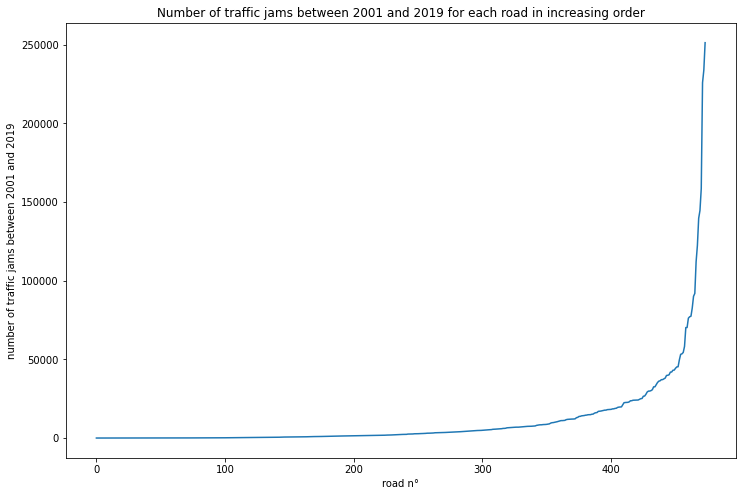

In [ ]:
fig = plt.figure(figsize=(12,8))

plt.plot(gs.sort(list(jam_count.values())))
plt.xlabel("road n°")
plt.ylabel("number of traffic jams between 2001 and 2019")
plt.title("Number of traffic jams between 2001 and 2019 for each road in increasing order")
plt.show()

In [ ]:
list_jam_count = gs.sort(list(jam_count.values()))
cdf = [list_jam_count[0]]
for i in range(len(list_jam_count)):
    cdf.append(cdf[i] + list_jam_count[i])

cdf = cdf / cdf[-1]

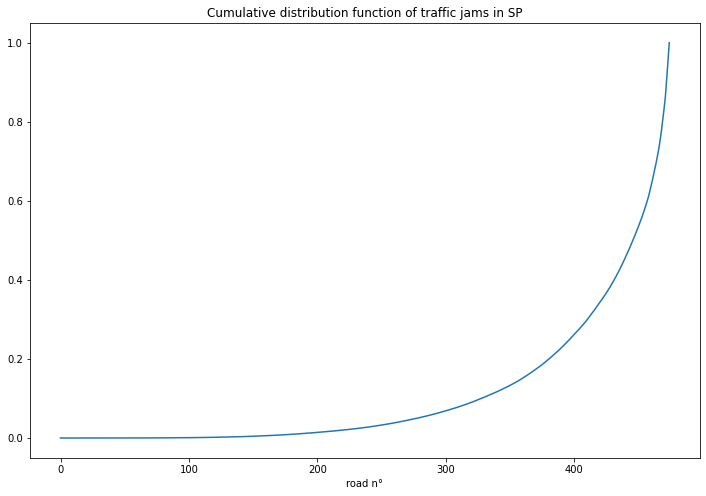

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(cdf)

plt.xlabel("road n°")
plt.title("Cumulative distribution function of traffic jams in SP")
plt.show()

The 75 most congestioned roads make up for 75% of all traffic jams in Sao Paulo. That is where we will focus our renovation efforts.

In [ ]:
roads_to_renovate = sorted_jam_count[-75:]

In [ ]:
roads_to_renovate
passages_to_renovate, directions_to_renovate = [], []
for road in roads_to_renovate:
    passages_to_renovate.append(road[:40])
    directions_to_renovate.append(road[40:])

# 3. Mathematical modeling

## 3.1. Introduction of the Gamma manifold

The modeling of the study relies heavily on the representation of a traffic jam as a random variable.
In fact, the waiting time in a given traffic jam can be predicted by a Gamma distribution.

Indeed, as a $\nu$-exponential process predicts the waiting time until one very first event (where $\nu$ is a rate of a unit of time), a $(k,\, \nu)$-Gamma process will predict the waiting time until the $k$-th event: mathematically, it is the sum of $k$ i.i.d $\nu$-exponential processes.

That is essentially what happens in a traffic jam: you wait until every car in front of you has exited the traffic jam. Switching lanes rarely helps, and if so, to a negligible extent, furthermore a car entering the traffic jam will almost always choose the least crowded lane (all drivers are a priori mentally sane). These two observations allow to reduce the modeling of a whole traffic jam to that of a single lane, although only in representation, beacuse cars next to each other will have the same behavior.

This is why we can see a traffic jam as the iteration of a given number of cars, whose waiting times when entering the traffic jam follow a Gamma distribution. Its parameters are $k$ (the number of cars in front of the car in arbitrary units) and $\nu$ (the exit time rate of the traffic jam, i.e. the number of cars (in the same arbitrary unit) that exit the traffic jam in a given amount of time, so essentially the speed of the traffic jam).

Thus, the waiting time $t$ in a given traffic jam follows the distribution:
$$p(t|k, \nu) = \frac{\nu^k}{\Gamma(k)} t^{k-1} e^{-\nu t}.

For the following, we denote Gamma distributions' parameters by $(\kappa, \gamma)$, where $\kappa$=$k$ (number of agents) and $\gamma$=$\frac{k}{\nu}$ is the expected congestion time (mean of the Gamma distribution).

In [ ]:
import matplotlib.pyplot as plt
from geomstats.information_geometry.gamma import *

space = GammaDistributions()

For instance, on the following graph we are plotting 10 roads with random parameters between 0 and 5, meaning that in arbitrary units, all car lanes are of length below 5 and the expected waiting time in traffic is below 5 time units.

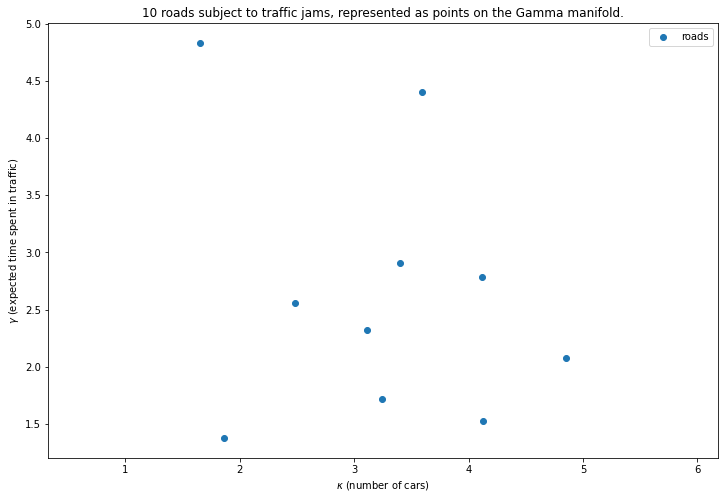

In [ ]:
road = space.random_point(10)
fig = plt.figure(figsize=(12,8))
plt.scatter(road[:,0], road[:,1], label = 'roads')
plt.xlabel("$\\kappa$ (number of cars in arbitrary units)")
plt.ylabel("$\\gamma$ (expected time spent in traffic)")
plt.title("10 roads subject to traffic jams, represented as points on the Gamma manifold.")
plt.legend()
plt.xlim(0,5)
plt.ylim(0,5)
plt.axis("equal")
plt.show()

## 3.2. Mathematical interpretation of an effort of renovation

This is where information geometry comes in handy.

Renovating a road initially aims at reducing the expected time spent in traffic. But, first, the efficiency of the renovation in that regard heavily depends on the road (renovating a fluid road will be of little use), and second, it can bring other unwanted consequences, for example increasing the expected number of cars at the entrance of the jam (cars will be faster but there will be longer lanes).

This is a phenomenon that can be observed through information geometry: by seeing renovation as an effort in reducing the expected time in traffic, we can model the advancement of the renovation as the geodesic departing from the point representation of the road, and with initial tangent vector in the direction and orientation $-\gamma$. This reflects the fact that the advancement of the renovation will follow the most natural path, i.e. the distribution of the waiting time of the associated road will change as little as possible throughout the renovation.

The amount of effort invested in the renovation of a given road can be directly represented by the norm of the tangent vector.

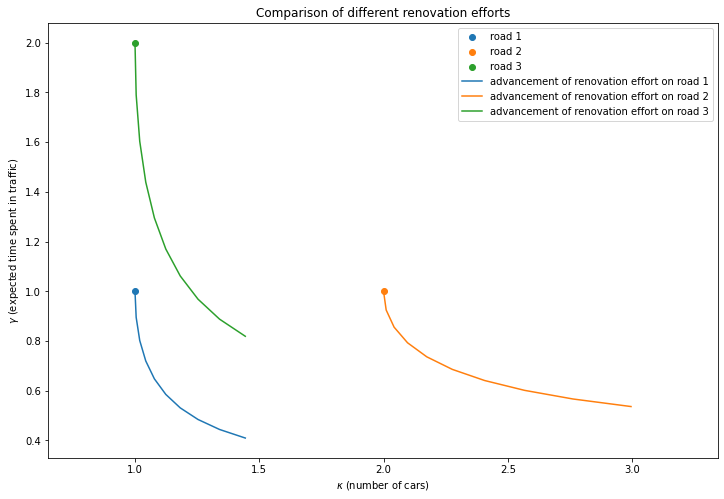

Road 1 renovation: waiting time has decreased from 1.0 to 0.409, number of cars has increased from 1.0 to 1.443.
Road 2 renovation: waiting time has decreased from 1.0 to 0.536, number of cars has increased from 2.0 to 2.995.
Road 3 renovation: waiting time has decreased from 2.0 to 0.818, number of cars has increased from 1.0 to 1.443.


In [ ]:
fig = plt.figure(figsize=(12,8))

t = gs.linspace(0,1,10)

road1 = gs.array([1.0,1.0])
plt.scatter(*road1, label = 'road 1')

road2 = gs.array([2.0,1.0])
plt.scatter(*road2, label = 'road 2')

road3 = gs.array([1.0,2.0])
plt.scatter(*road3, label = 'road 3')

effort = gs.array([0.0, -1.0])

effort1 = space.metric.normalize(effort, road1)
renovation1 = space.metric.geodesic(initial_point=road1, initial_tangent_vec=effort1)
renovation1 = renovation1(t)
plt.plot(*gs.transpose(renovation1), label = 'advancement of renovation effort on road 1')

effort2 = space.metric.normalize(effort, road2)
renovation2 = space.metric.geodesic(initial_point=road2, initial_tangent_vec=effort2)
renovation2 = renovation2(t)
plt.plot(*gs.transpose(renovation2), label = 'advancement of renovation effort on road 2')

effort3 = space.metric.normalize(effort, road3)
renovation3 = space.metric.geodesic(initial_point=road3, initial_tangent_vec=effort3)
renovation3 = renovation3(t)
plt.plot(*gs.transpose(renovation3), label = 'advancement of renovation effort on road 3')

plt.xlabel("$\\kappa$ (number of cars)")
plt.ylabel("$\\gamma$ (expected time spent in traffic)")

plt.title("Comparison of different renovation efforts")

plt.legend()
plt.axis("equal")

plt.show()

print(f"Road 1 renovation: waiting time has decreased from {road1[1]} to {str(renovation1[-1,1])[:5]}, number of cars has increased from {road1[0]} to {str(renovation1[-1,0])[:5]}.")
print(f"Road 2 renovation: waiting time has decreased from {road2[1]} to {str(renovation2[-1,1])[:5]}, number of cars has increased from {road2[0]} to {str(renovation2[-1,0])[:5]}.")
print(f"Road 3 renovation: waiting time has decreased from {road3[1]} to {str(renovation3[-1,1])[:5]}, number of cars has increased from {road3[0]} to {str(renovation3[-1,0])[:5]}.")


In the example above, the same amount of effort has been put to renovate 3 roads, as all initial tangent vectors are of norm $1$:
- road 1 corresponds to $\kappa$ = 1 (length of car lane), $\gamma$ = 1 (expected time spent in traffic);
- road 2 to $\kappa$ = 2, $\gamma$ = 1;
- road 3 to $\kappa$ = 1, $\gamma$ = 2.

We observe that it is much more efficient to renovate road 3 rather than road 1 in terms of gained expected waiting time. In terms of relative time gain however, the result is the same: this is specific to Gamma distributions. In addition, renovating road 3 is more efficient than renovating road 2, either in absolute or relative time gain. We observe furthermore that investing similar efforts in renovating roads 3 and 2 result in  different evolutions regarding the length of the car line: it increases by 44% in the first case and by as much as 50% in the second one. This becomes delicate especially considering the expected car line on road 2 was already long.

The fact that these results validate expected consequences of renovations encourages us once again indeed to use information geometry to model the situation. For instance, a euclidean modeling of the situation would make no sense!

Therefore, the key to optimizing Sao Paulo's traffic obviously lies in maximizing the efficiency of the renovation, with limited renovation resources.

## 3.3. Optimization problem

The aim is to minimize the mean expected congestion time in Sao Paulo, weighted by the frequencies $f_i$ of traffic jams $1 \leq i \leq n$, under the constraint of a total quantity of resources $r$. This reads:

\begin{equation}
\begin{cases}
\min_{(r_i)}  \sum_{i=1}^n f_i \times \exp_{x_i} \left( r_i \times \left(\begin{array}{c} 0 \\ -1 \end{array}\right)_{x_i} \right)_{\gamma} \\
\forall i \in \{1,...,n\}, r_i \geq 0 \\
\sum_{1 \leq i \leq n} r_i = r \\
\end{cases},
\end{equation}


where:
- $(x_i)$ are the roads;
- $\left(\begin{array}{c} 0 \\ -1 \end{array}\right)_{x_i}$ is the unit tangent vector at $x_i$ with direction and orientation $-\gamma$;
- $\exp_{x_i}$ is the exponential map at $x_i$;
- for $x \in G$ (the Gamma manifold), $x_{\gamma}$ is its $\gamma$ coordinate;
- $r_i$ is the resource allocated for renovating road $i$.

#### Remark

We could rewrite the problem in a simpler way analytically, making use of the following results:
- the relative efficiency of renovation (i.e. the ratio of expected congestion times) does not depend on the original expected congestion time of the road ($\gamma$);
- similarly, the jam size of the renovated road does not depend on the original expected congestion time of the road ($\gamma$).

However, we will not use these results to make way for a better computational solution of the problem.


# 4. Dataset processing

First, we associate to each of the roads eligible for renovation its parameters for a Gamma distribution, through a maximum likelihood fit of the durations of traffic jams.

In [ ]:
passages, directions, kappas, gammas = [], [], [], []

LENGTH = len(roads_to_renovate)

pbar = tqdm(total=LENGTH)

for i in range(LENGTH):
    pbar.update(n=1)
    passage, direction = passages_to_renovate[i], directions_to_renovate[i]
    frame = df.loc[(df["passage"] == passage) & (df["direction"] == direction)]
    sample = frame["duration"]
    try:
        kappa, gamma = space.maximum_likelihood_fit(sample)
        if not(gs.any(gs.isnan([kappa, gamma]))):
            passages.append(passage)
            directions.append(direction)
            kappas.append(kappa)
            gammas.append(gamma)
    except:
        continue

100%|██████████| 75/75 [00:03<00:00, 19.99it/s]

Having focused on the 75 most congestioned roads makes sense now, as the estimations for the Gamma parameters of the roads is much more relevant. Accounting for all the roads would result in having outliers in our set of roads, rendering the computation far more complex. In addition, roads with a negligible count of traffic jams in such a long time span do not necessarily call for renovation.

That is why, for the following and for the problem at hand, we can consider the following simplification: the roads eligible for renovation represent SP's roads subject to traffic jams, i.e. the exact dataset we want to be working on.

In [ ]:
dict_parameters = {"passage": passages, "direction": directions, "kappa": kappas, "gamma": gammas}
data = pd.DataFrame.from_dict(dict_parameters)

To each of the roads eligible for renovation we associate a weight proportional to the number of traffic jams between 2001 and 2019.

In [ ]:
good_points = list(data["passage"] + data["direction"])
weights = list(map(jam_count.get, good_points))
weights = weights / gs.sum(weights)

The 75 most congestioned roads of SP can be represented as follows on the Gamma manifold.

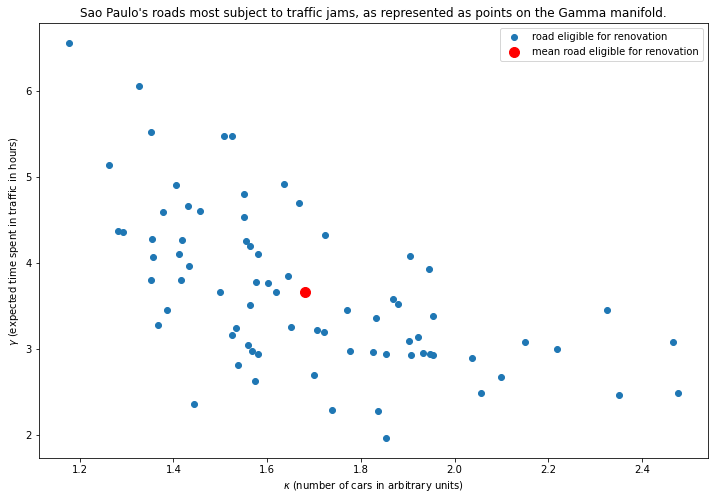

In [ ]:
kappa, gamma = data["kappa"], data["gamma"]

fig = plt.figure(figsize=(12,8))

mean = gs.array([gs.mean(weights*kappa), gs.mean(weights*gamma)])

plt.scatter(kappa, gamma, label='road eligible for renovation')
plt.scatter(*mean, color = 'r', s=100, label='mean road eligible for renovation')
plt.xlabel("$\\kappa$ (number of cars in arbitrary units)")
plt.ylabel("$\\gamma$ (expected time spent in traffic in hours)")
plt.title("Sao Paulo's roads most subject to traffic jams, as represented as points on the Gamma manifold.")
plt.legend()
plt.show()

We observe that the vast majority of traffic jams in SP can take from 2 to 6+ hours of congestion time. On the most impactful roads (eligible for renovation), the mean waiting time is 4h 15min.

# 5. Solving the problem at hand

Arbitrarily (and for computational purposes), we are allocated a total of 5 resources to allocate on the renovations.

In [ ]:
total_resources = 5

In [ ]:
points = gs.transpose(gs.stack([kappa, gamma]))
n_points = len(points)

We optimize the allocation of resources for renovation here:

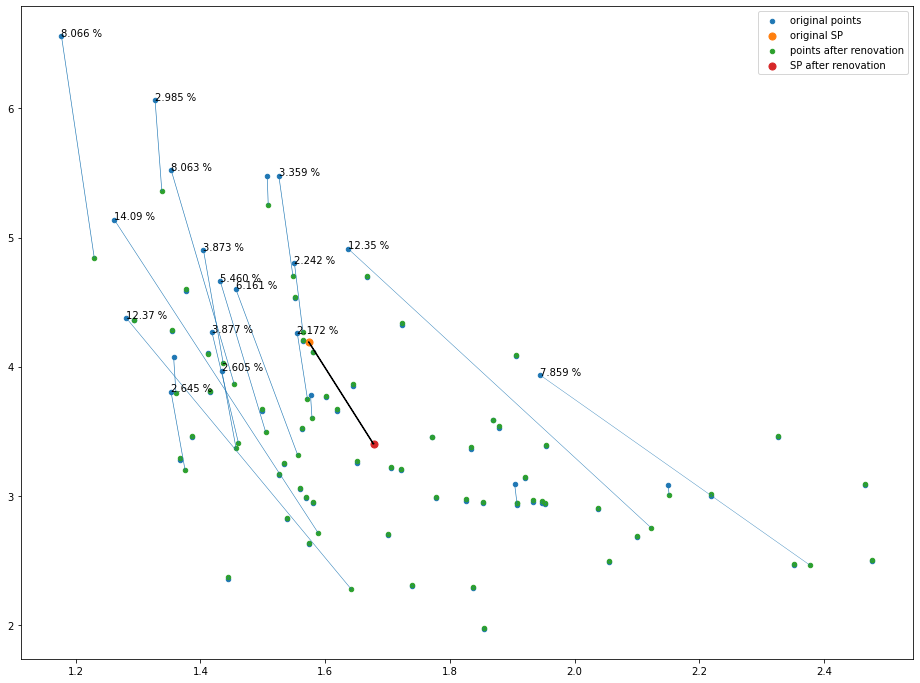

In [ ]:
original_SP = gs.sum(gs.einsum("...,...j->...j", weights, points), axis=0)

def rebuilding(point, resources):
    n_points = point.shape[0] if len(point.shape)>1 else 1
    vec = gs.tile([gs.array([0.0,-1.0])], (n_points, 1))
    norm = resources * total_resources
    tangent_vec = gs.einsum("...,...j->...j", norm, vec)
    end_point = space.metric.exp(tangent_vec, point, n_steps=100)
    return end_point

def objective(resources):
    end_points = rebuilding(points, resources)
    gammas = end_points[:,1]
    return gs.mean(weights*gammas)

objective_with_grad = gs.autodiff.value_and_grad(objective, to_numpy=True)

resources = total_resources * weights

res = minimize(
    objective_with_grad,
    resources,
    method="SLSQP",
    constraints=({'type': 'ineq', 'fun': lambda x: total_resources - gs.sum(x)},
    {'type': 'ineq', 'fun': lambda x: x.min()},
    ),
    jac=True,
    options={"disp": False, "maxiter": 100},
    tol=gs.atol,
)

resources = res.x

new_points = rebuilding(points, resources)

fig = plt.figure(figsize=(16,12))

plt.scatter(points[:,0], points[:,1], label = 'original points', s=20)

plt.scatter(*original_SP, label = 'original SP', s=50)

plt.scatter(new_points[:,0], new_points[:,1], label = 'points after renovation', s=20)

for i in range(n_points):
    percentage = resources[i] * 100 / total_resources
    if percentage > 2:
        plt.text(points[i,0], points[i,1], f"{str(resources[i] * 100 / total_resources)[:5]} %")
    plt.arrow(points[i,0], points[i,1], (new_points - points)[i,0], (new_points - points)[i,1], head_width=.01 linestyle ="", length_includes_head = True)

new_SP = gs.sum(gs.einsum("...,...j->...j", weights, new_points), axis=0)

plt.scatter(*new_SP, label = 'SP after renovation', s=50)

plt.arrow(*original_SP, *(new_SP - original_SP), head_width=.05 linestyle = "-", length_includes_head = True)

plt.xlabel("$\\kappa$ (number of cars in arbitrary units)")
plt.ylabel("$\\gamma$ (expected time spent in traffic in hours)")

plt.title("Optimization of SP's traffic")

plt.legend()

plt.show()

Above, the percentages represent the proportion of the total resources that have been allocated to the renovation of each road: they are visible if greater than 2%.

# Conclusion

We have managed to substantially reduce the mean expected congestion time in SP, not at great expense of the lane sizes. We also happen to have reduced the variance of the mean congestion time. This is a great success!